<a href="https://colab.research.google.com/github/yutao-data/Sepsis_Gene_KnowledgeGraph_Ontology/blob/main/Sepsis_Dataset_Exploring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gprofiler
!pip install GEOparse
!pip install owlready2
!pip install gprofiler-official

In [25]:
import requests
from gprofiler import GProfiler
import GEOparse
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind
from owlready2 import *
import warnings
from itertools import combinations
from io import StringIO
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Data

In [4]:
warnings.filterwarnings("ignore")

onto = get_ontology("http://purl.obolibrary.org/obo/go.owl").load()
ppio_ontology = get_ontology("/content/drive/MyDrive/stagelisn2024-main/PPI_Onto.owl").load()
onto.imported_ontologies.append(ppio_ontology)

In [5]:
def get_term_id(term_label):
    '''Function to get term ID from PPIO ontology
    @param a string of standard protein name

    '''
    for term in onto.classes():
        if term.label and term_label.lower() in term.label[0].lower():
            return term.name, term.iri
    return None, None


# Load GEO dataset and GPL annotations
gse = GEOparse.get_GEO(filepath="/content/drive/MyDrive/stagelisn2024-main/data/GSE54514_family.soft.gz", silent=True)
gpl_annotations = pd.read_csv("/content/drive/MyDrive/stagelisn2024-main/data/GPL6947-13512.txt", sep="\t", comment='#')

# Map probes to gene IDs
probe_to_gene = gpl_annotations[['ID', 'Entrez_Gene_ID']]
probe_to_gene = probe_to_gene.dropna(subset=['Entrez_Gene_ID'])
probe_to_gene['Entrez_Gene_ID'] = probe_to_gene['Entrez_Gene_ID'].astype(int)

sample_status = [gsm.metadata["characteristics_ch1"][1].split(": ")[1] for gsm in gse.gsms.values()]

expression_data = pd.DataFrame()
for gsm_name, gsm in gse.gsms.items():
    expression_data[gsm_name] = gsm.table.set_index("ID_REF")["VALUE"]

expression_data = expression_data.T
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
expression_data.dropna(axis=1, inplace=True)

sample_info = pd.DataFrame({"Sample": expression_data.index, "Status": sample_status})

group1 = sample_info[sample_info["Status"] == "healthy"]["Sample"]
group2 = sample_info[sample_info["Status"] != "healthy"]["Sample"]
print("dataset has loaded succesfully")

dataset has loaded succesfully


In [6]:
p_values = np.array([ttest_ind(expression_data.loc[group1, gene],
                               expression_data.loc[group2, gene])[1]
                     for gene in expression_data.columns])

_, p_adjusted, _, _ = multipletests(p_values, method='fdr_bh')

degs = expression_data.columns[p_adjusted < 0.01]

degs_symbols = probe_to_gene[probe_to_gene['ID'].isin(degs)]
degs_symbols = degs_symbols.drop_duplicates(subset=['Entrez_Gene_ID'])

In [7]:
# Select DEGs and their corresponding probes
selected_genes = degs_symbols['Entrez_Gene_ID'].astype(str).tolist()
selected_probes = degs_symbols[degs_symbols['Entrez_Gene_ID'].astype(str).isin(selected_genes)]['ID']

# Create a dictionary mapping probe IDs to Entrez Gene IDs
probe_to_entrez = dict(zip(probe_to_gene['ID'], probe_to_gene['Entrez_Gene_ID'].astype(str)))

# Subset expression data for selected probes
expression_degs = expression_data[selected_probes]

# Calculate correlation matrix using Spearman correlation
correlation_matrix = expression_degs.corr(method='spearman')

# Identify co-expressed gene pairs based on a correlation threshold
co_expression_edges = []
threshold = 0.8
for probe1 in correlation_matrix.columns:
    for probe2 in correlation_matrix.columns:
        if probe1 != probe2 and correlation_matrix.loc[probe1, probe2] > threshold:
            gene1 = probe_to_entrez[probe1]
            gene2 = probe_to_entrez[probe2]
            co_expression_edges.append((gene1, gene2))

print(f"Number of co-expressed gene pairs found: {len(co_expression_edges)}")

Number of co-expressed gene pairs found: 768


In [8]:
def get_go_annotations(gene_symbols):
    '''Function to get GO annotations
    @param list of entrez gene ID
    @return two df, one for the GO results and one for the expressed related proteins
    '''
    gp = GProfiler(return_dataframe=True)
    go_results = gp.profile(
        organism='hsapiens',
        query=gene_symbols,
        no_evidences=False,
        sources=["GO:CC", "GO:BP", 'GO:MF']
    )
    protein_results = gp.convert(
        organism='hsapiens',
        query=gene_symbols,
        target_namespace='PROTEIN_ID',
        numeric_namespace='ENTREZGENE_ACC'
    )
    return go_results, protein_results

In [9]:
def get_protein_interactions(protein_names):
    '''Function to get protein interactions from STRING
    @param list (string) of protein standard name *
    @return a df for the interactions and probability of occuring (not the nature of the interaction)
    '''
    string_api_url = "https://version-11-5.string-db.org/api"
    output_format = "tsv-no-header"
    method = "interaction_partners"
    request_url = "/".join([string_api_url, output_format, method])

    params = {
        "identifiers": "%0d".join(protein_names),
        "species": 9606,
        "limit": 5,
        "caller_identity": "KG Sepsis"
    }

    response = requests.post(request_url, data=params)
    interactions = []
    for line in response.text.strip().split("\n"):
        l = line.strip().split("\t")
        query_name = l[2]
        partner_name = l[3]
        combined_score = l[5]
        interactions.append((query_name, partner_name, combined_score))

    return interactions

In [10]:
gene_symbols = selected_genes

go_results, protein_results = get_go_annotations(gene_symbols)
go_results = go_results.drop_duplicates('native')
protein_results = protein_results.drop_duplicates('incoming')
print("Annotations succesfully retrived")

Annotations succesfully retrived


In [14]:
def get_biogrid_interactions(proteins, taxon_id=9606, api_key='2288556b908f441f022341112c9c9c08'):
    ''' Function to get BioGRID interactions, can be relatively slow
    @param list of proteins in their standard id (do not modify other parameters, taxon id being the specie where 9606 is Homo Sapiens)
    @return a df with the interactions of the listed proteins and their nature
    '''
    url = "https://webservice.thebiogrid.org/interactions/"
    params = {
        "searchNames": "true",
        "geneList": "|".join(proteins),
        "taxId": taxon_id,
        "includeInteractors": "true",
        "includeEvidence": "false",
        "accesskey": api_key,
        "format": "tab25"
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        interactions = StringIO(response.text)
        column_names = [
            'BioGRID Interaction ID', 'Entrez Gene Interactor A', 'Entrez Gene Interactor B', 'BioGRID ID Interactor A',
            'BioGRID ID Interactor B', 'Systematic Name Interactor A', 'Systematic Name Interactor B',
            'Official Symbol Interactor A', 'Official Symbol Interactor B', 'Synonyms Interactor A',
            'Synonyms Interactor B',
            'Experimental System', 'Experimental System Type', 'Author', 'Pubmed ID', 'Organism Interactor A',
            'Organism Interactor B', 'Throughput', 'Score', 'Modification', 'Phenotypes', 'Qualifications', 'Tags',
            'Source Database'
        ]
        df = pd.read_csv(interactions, sep='\t', names=column_names, header=None)
        filtered_df = df[df['Modification'] != '-']
        return filtered_df
    else:
        print(f"HTTP Error: {response.status_code}")
        return None


proteins = protein_results['name'].tolist()
biogrid_interactions = get_biogrid_interactions(proteins)
print("Interactions succesfully loaded")

Interactions succesfully loaded


## Data Analysis

In [15]:
# Number of samples and gene probes
num_samples = expression_data.shape[0]
num_probes = expression_data.shape[1]

print(f"Number of samples: {num_samples}")
print(f"Number of probes: {num_probes}")

# Distribution of sample health status
status_distribution = sample_info["Status"].value_counts()
print(f"Sample status distribution:\n{status_distribution}")

# Statistical description of expression levels
expression_stats = expression_data.describe()
print("Expression Data Statistics:\n", expression_stats)

# Number of differentially expressed genes (DEGs) and list of genes
print(f"Number of DEGs: {len(degs)}")
print(f"DEGs Symbols:\n{degs_symbols['Entrez_Gene_ID'].tolist()}")

# GO annotation information
go_counts = Counter(go_results["source"])
go_stats = pd.DataFrame.from_dict(go_counts, orient='index', columns=['Count'])
print("GO Annotation Counts:\n", go_stats)

# Sample of protein-protein interactions from BioGRID
biogrid_interactions_summary = biogrid_interactions[['Official Symbol Interactor A', 'Official Symbol Interactor B', 'Experimental System']].head(10)
print("BioGRID Interactions (Sample):\n", biogrid_interactions_summary)

# Detailed output of all gene expression data statistics
print("Gene Expression Data:\n", expression_data.head())

# Sample information
print("Sample Information:\n", sample_info)

Number of samples: 163
Number of probes: 24840
Sample status distribution:
Status
sepsis survivor       96
healthy               36
sepsis nonsurvivor    31
Name: count, dtype: int64
Expression Data Statistics:
 ID_REF  ILMN_2055271  ILMN_2383229  ILMN_1806310  ILMN_1653355  ILMN_2359168  \
count     163.000000    163.000000    163.000000    163.000000    163.000000   
mean        7.196231      7.110817      7.125225      7.291736      7.090304   
std         0.110038      0.085517      0.116500      0.167868      0.055472   
min         6.956534      6.949070      6.937917      7.028317      6.973245   
25%         7.128342      7.059811      7.066124      7.189254      7.049623   
50%         7.184081      7.100916      7.105439      7.243145      7.085449   
75%         7.254160      7.139379      7.154292      7.351478      7.121301   
max         7.760832      7.732890      7.826385      8.301313      7.286322   

ID_REF  ILMN_1735045  ILMN_1680754  ILMN_1755321  ILMN_1698554  ILM

## Data Visualize

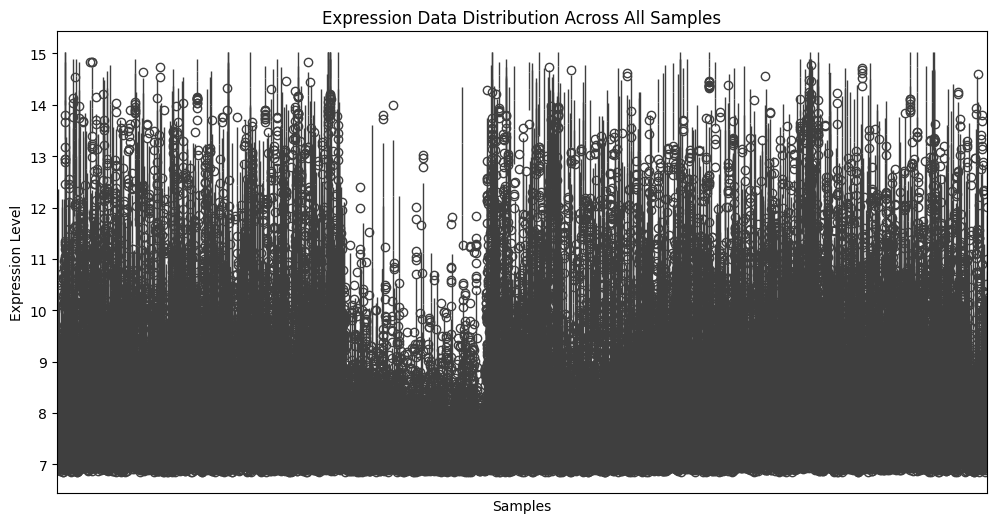

In [16]:
# Data Visualize
plt.figure(figsize=(12, 6))
sns.boxplot(data=expression_data)
plt.xticks([])
plt.title("Expression Data Distribution Across All Samples")
plt.xlabel("Samples")
plt.ylabel("Expression Level")
plt.show()

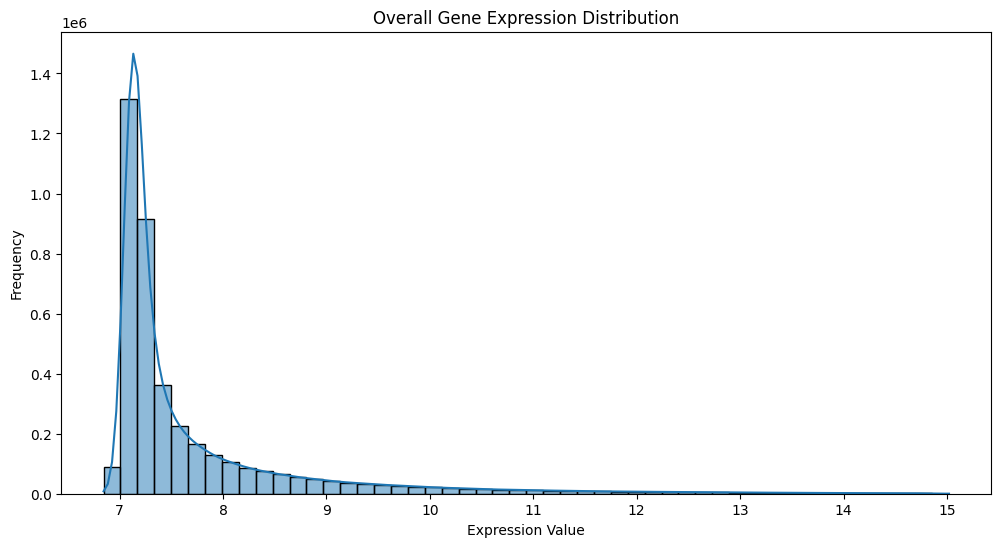

In [30]:
# Plot overall gene expression distribution
plt.figure(figsize=(12, 6))
sns.histplot(expression_data.values.flatten(), bins=50, kde=True)
plt.title('Overall Gene Expression Distribution')
plt.xlabel('Expression Value')
plt.ylabel('Frequency')
plt.show()

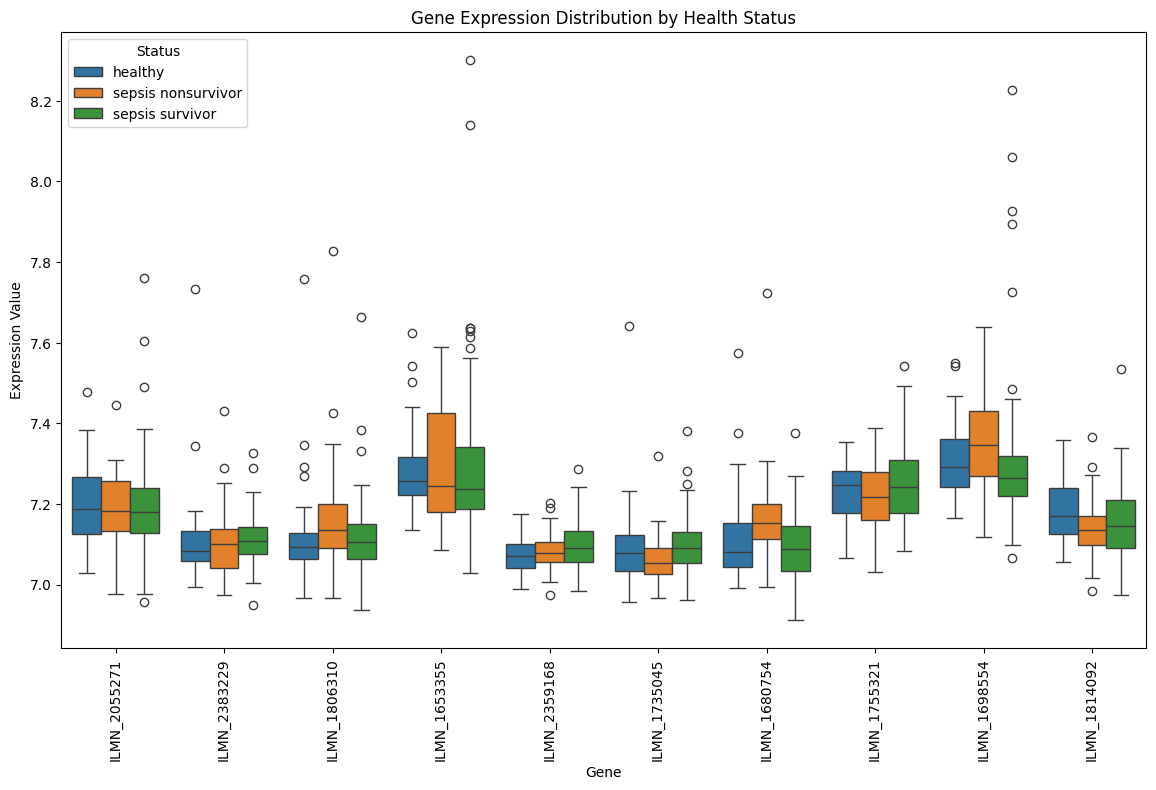

In [24]:
subset_genes = expression_data.columns[:10]
melted_data = pd.melt(expression_data[subset_genes].reset_index(), id_vars="index")
melted_data.columns = ["Sample", "Gene", "Expression"]
melted_data = melted_data.merge(sample_info, left_on="Sample", right_on="Sample")

plt.figure(figsize=(14, 8))
sns.boxplot(x='Gene', y='Expression', hue='Status', data=melted_data)
plt.title('Gene Expression Distribution by Health Status')
plt.xlabel('Gene')
plt.ylabel('Expression Value')
plt.xticks(rotation=90)
plt.show()

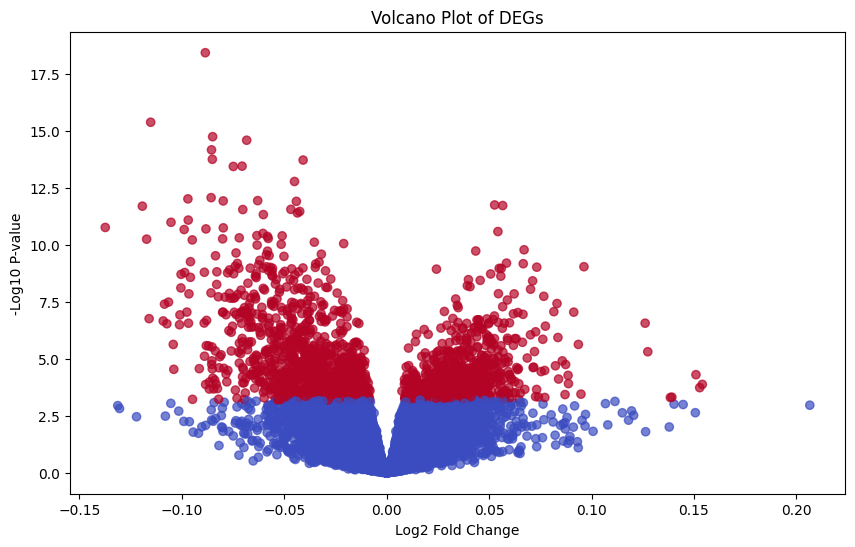

In [21]:
# Calculate log2 fold change
log_fold_changes = np.log2(expression_data.loc[group2].mean() / expression_data.loc[group1].mean())

# Volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(log_fold_changes, -np.log10(p_values), c=(p_adjusted < 0.01), cmap="coolwarm", alpha=0.7)
plt.title("Volcano Plot of DEGs")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-value")
plt.show()

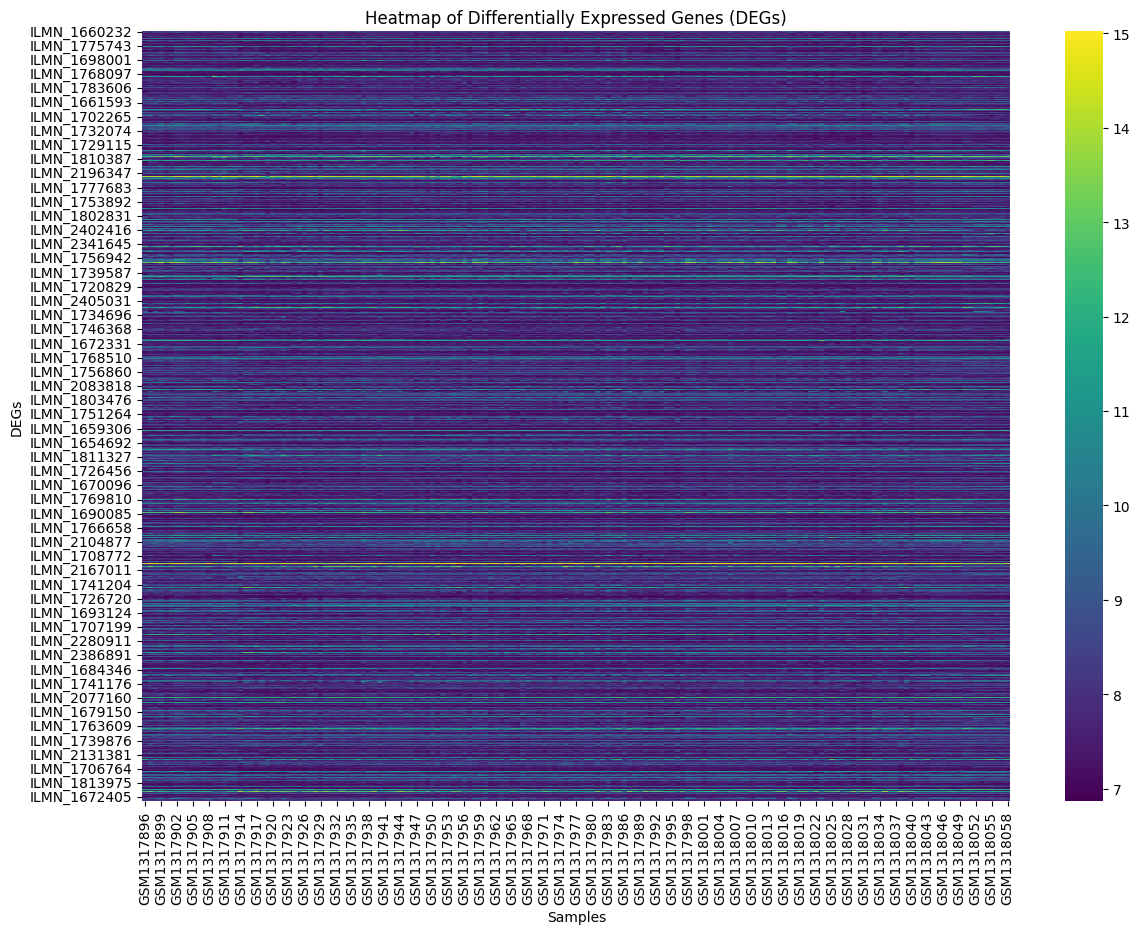

In [22]:
# Select DEGs expression data
degs_expression_data = expression_data[selected_probes]

# Heatmap of DEGs
plt.figure(figsize=(14, 10))
sns.heatmap(degs_expression_data.T, cmap="viridis", cbar=True)
plt.title("Heatmap of Differentially Expressed Genes (DEGs)")
plt.xlabel("Samples")
plt.ylabel("DEGs")
plt.show()

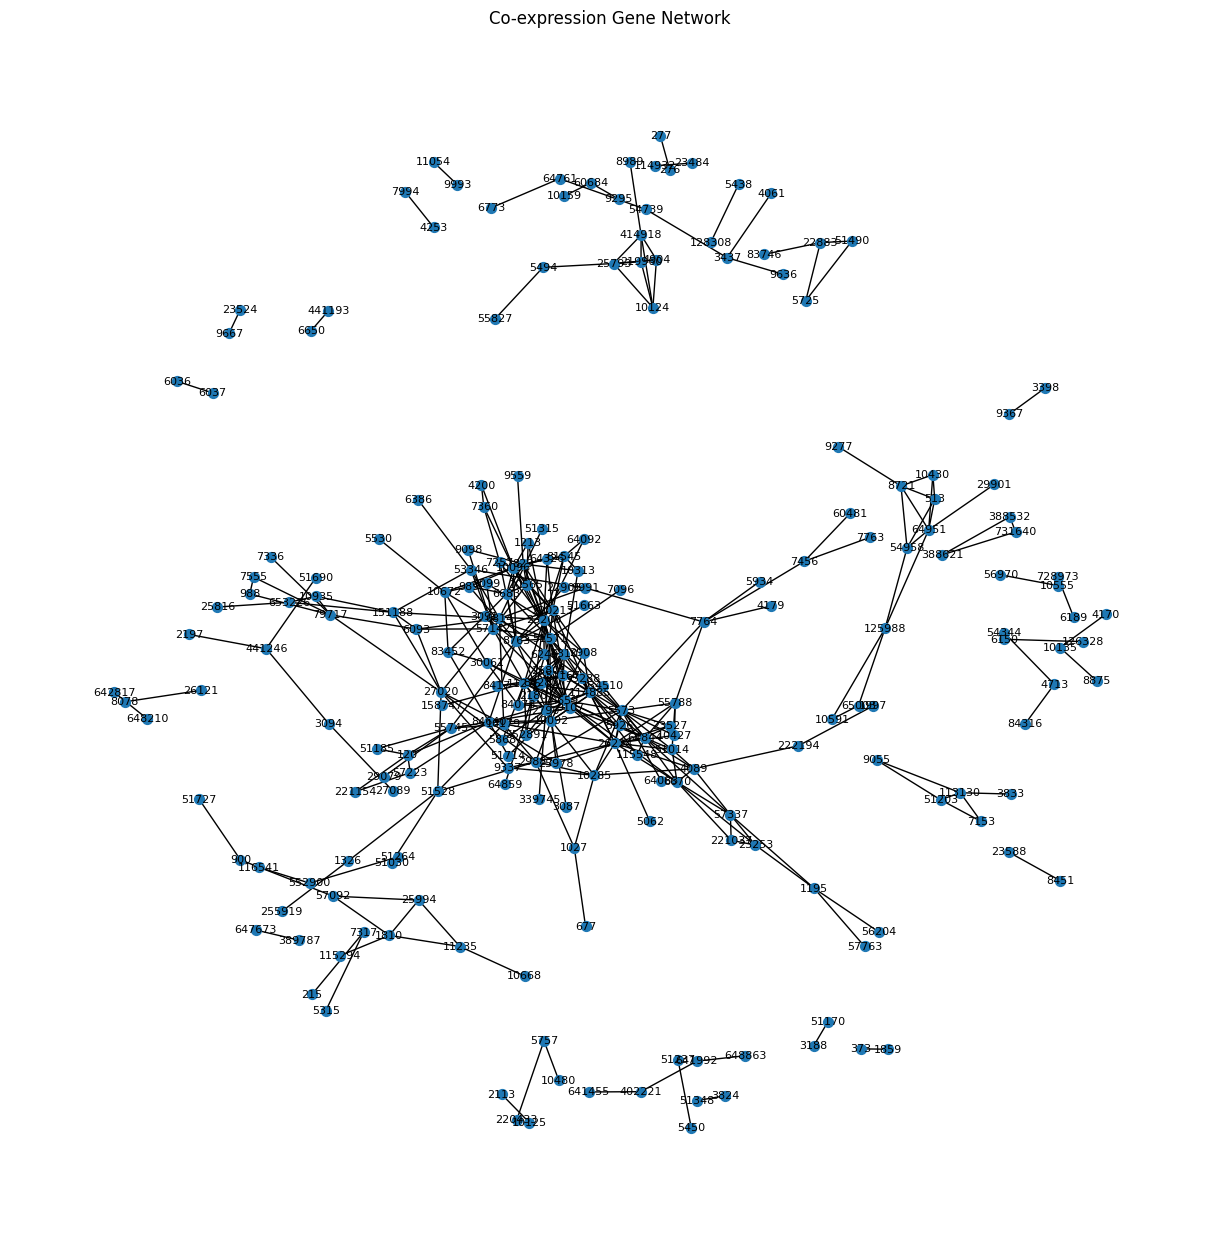

In [26]:
# Create a graph from co-expression edges
G = nx.Graph()
G.add_edges_from(co_expression_edges)

# Plot the co-expression network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
plt.title("Co-expression Gene Network")
plt.show()

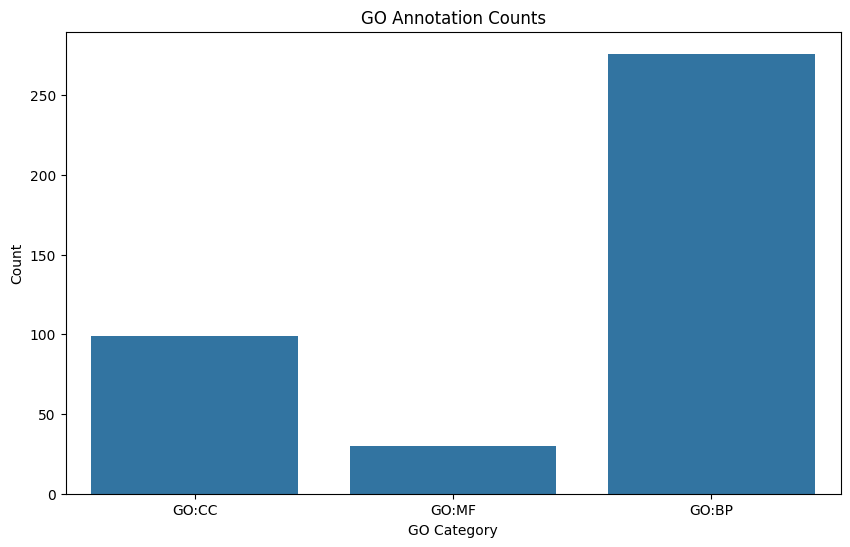

In [27]:
# Bar plot of GO annotation counts
plt.figure(figsize=(10, 6))
sns.barplot(x=go_stats.index, y='Count', data=go_stats)
plt.title("GO Annotation Counts")
plt.xlabel("GO Category")
plt.ylabel("Count")
plt.show()

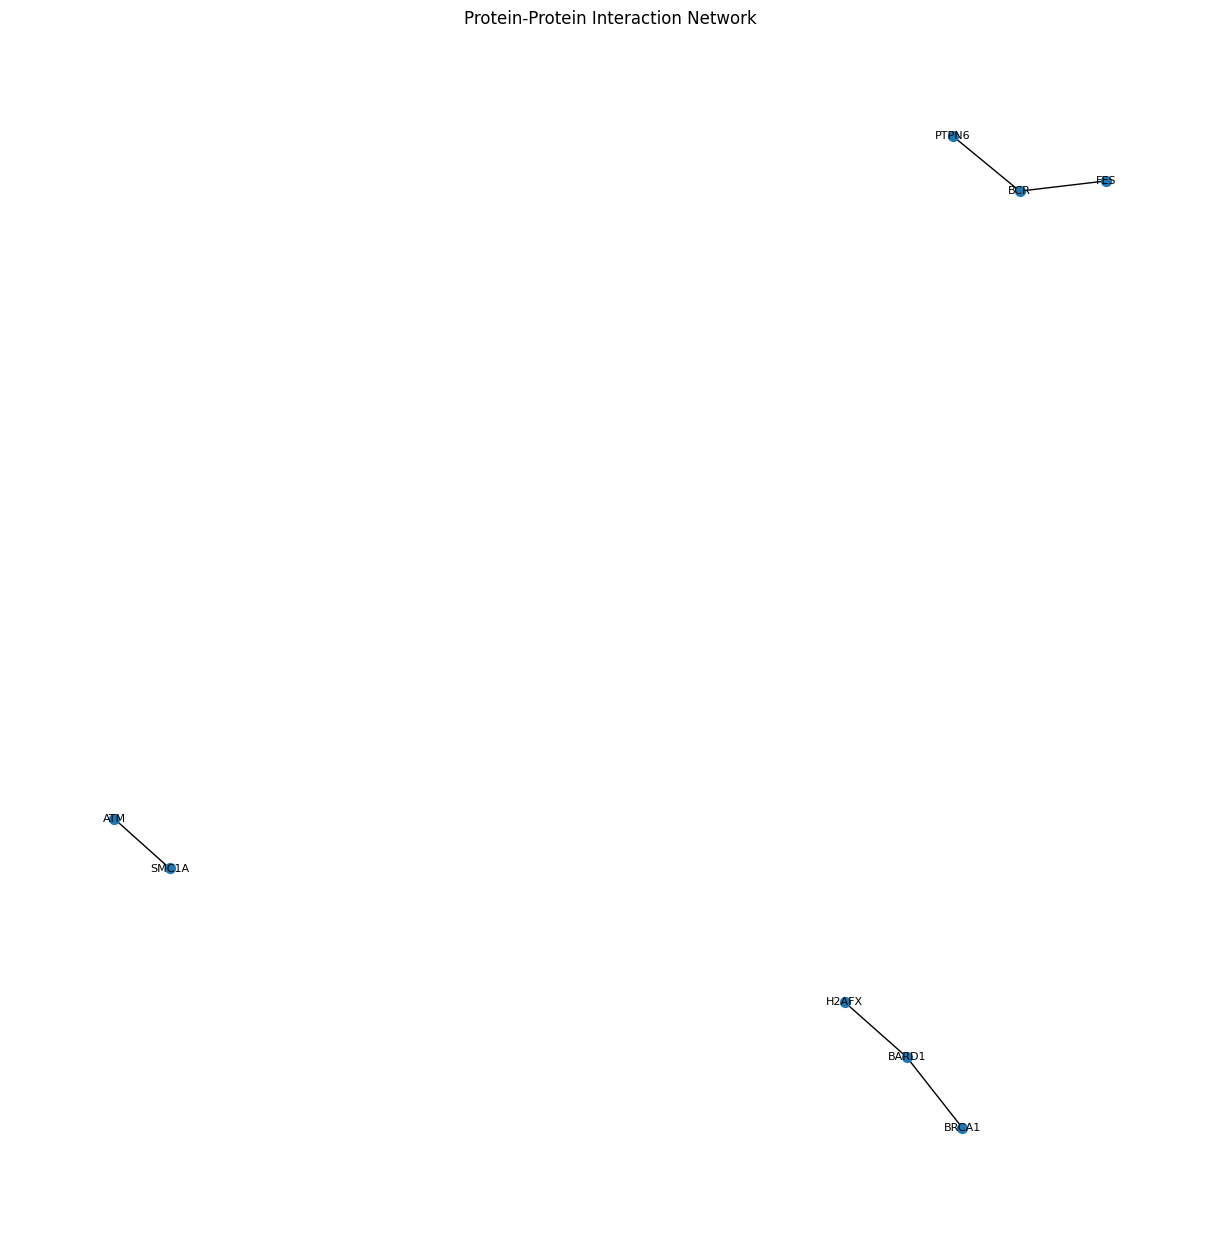

In [28]:
# Create a graph from BioGRID interactions
G_biogrid = nx.Graph()
for _, row in biogrid_interactions_summary.iterrows():
    G_biogrid.add_edge(row['Official Symbol Interactor A'], row['Official Symbol Interactor B'])

# Plot the protein-protein interaction network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_biogrid, k=0.15)
nx.draw(G_biogrid, pos, with_labels=True, node_size=50, font_size=8)
plt.title("Protein-Protein Interaction Network")
plt.show()

In [29]:
# Basic description of sample information
print("Sample Information Description:")
print(sample_info.describe())

Sample Information Description:
            Sample           Status
count          163              163
unique         163                3
top     GSM1317896  sepsis survivor
freq             1               96


## Pathways

In [34]:
def get_pathway_annotations(gene_symbols):
    '''Function to get pathway annotations
    @param list of entrez gene ID
    @return a dataframe with the pathway enrichment results
    '''
    gp = GProfiler(return_dataframe=True)
    pathway_results = gp.profile(
        organism='hsapiens',
        query=gene_symbols,
        no_evidences=False,
        sources=["REAC", "KEGG", "WP"]
    )
    return pathway_results

pathway_results = get_pathway_annotations(selected_genes)
print("Pathway analysis successfully retrieved")

top_pathways = pathway_results.sort_values(by='p_value').head(10)

Pathway analysis successfully retrieved


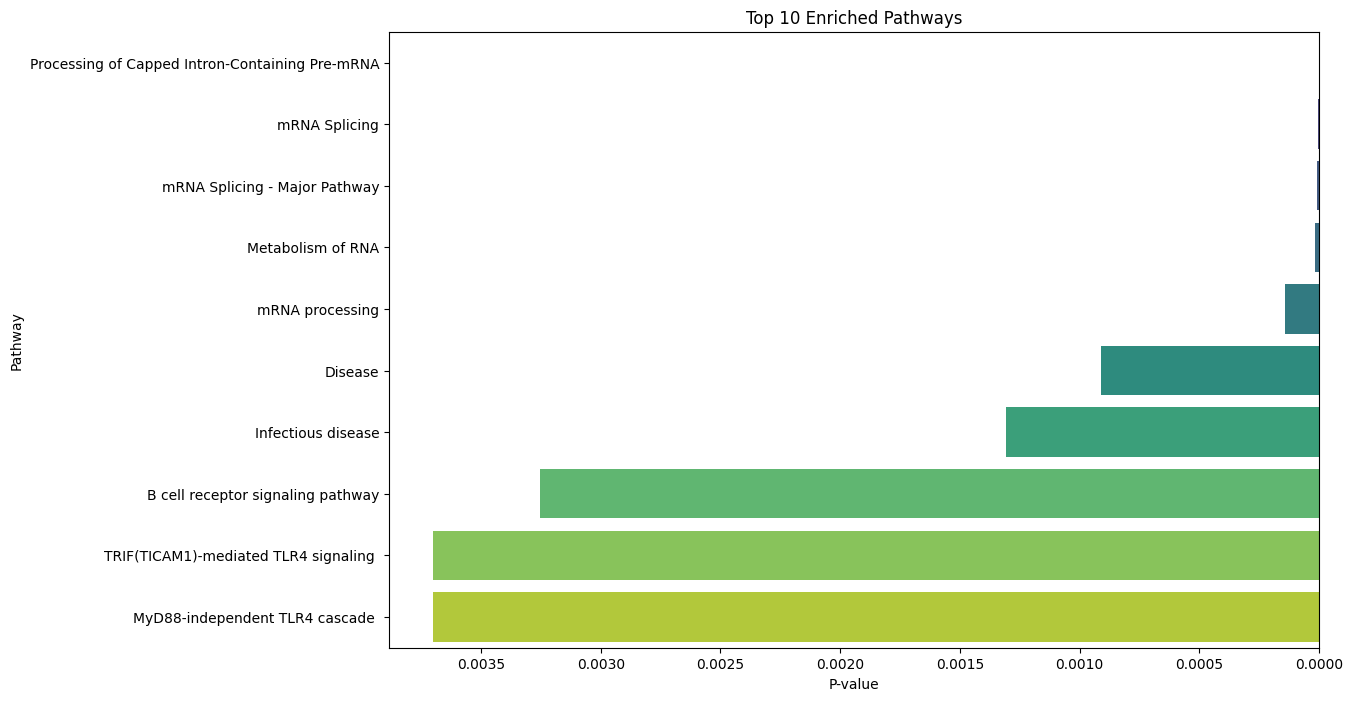

In [35]:
# Bar plot of top 10 pathways
plt.figure(figsize=(12, 8))
sns.barplot(x='p_value', y='name', data=top_pathways, palette='viridis')
plt.title('Top 10 Enriched Pathways')
plt.xlabel('P-value')
plt.ylabel('Pathway')
plt.gca().invert_xaxis()
plt.show()

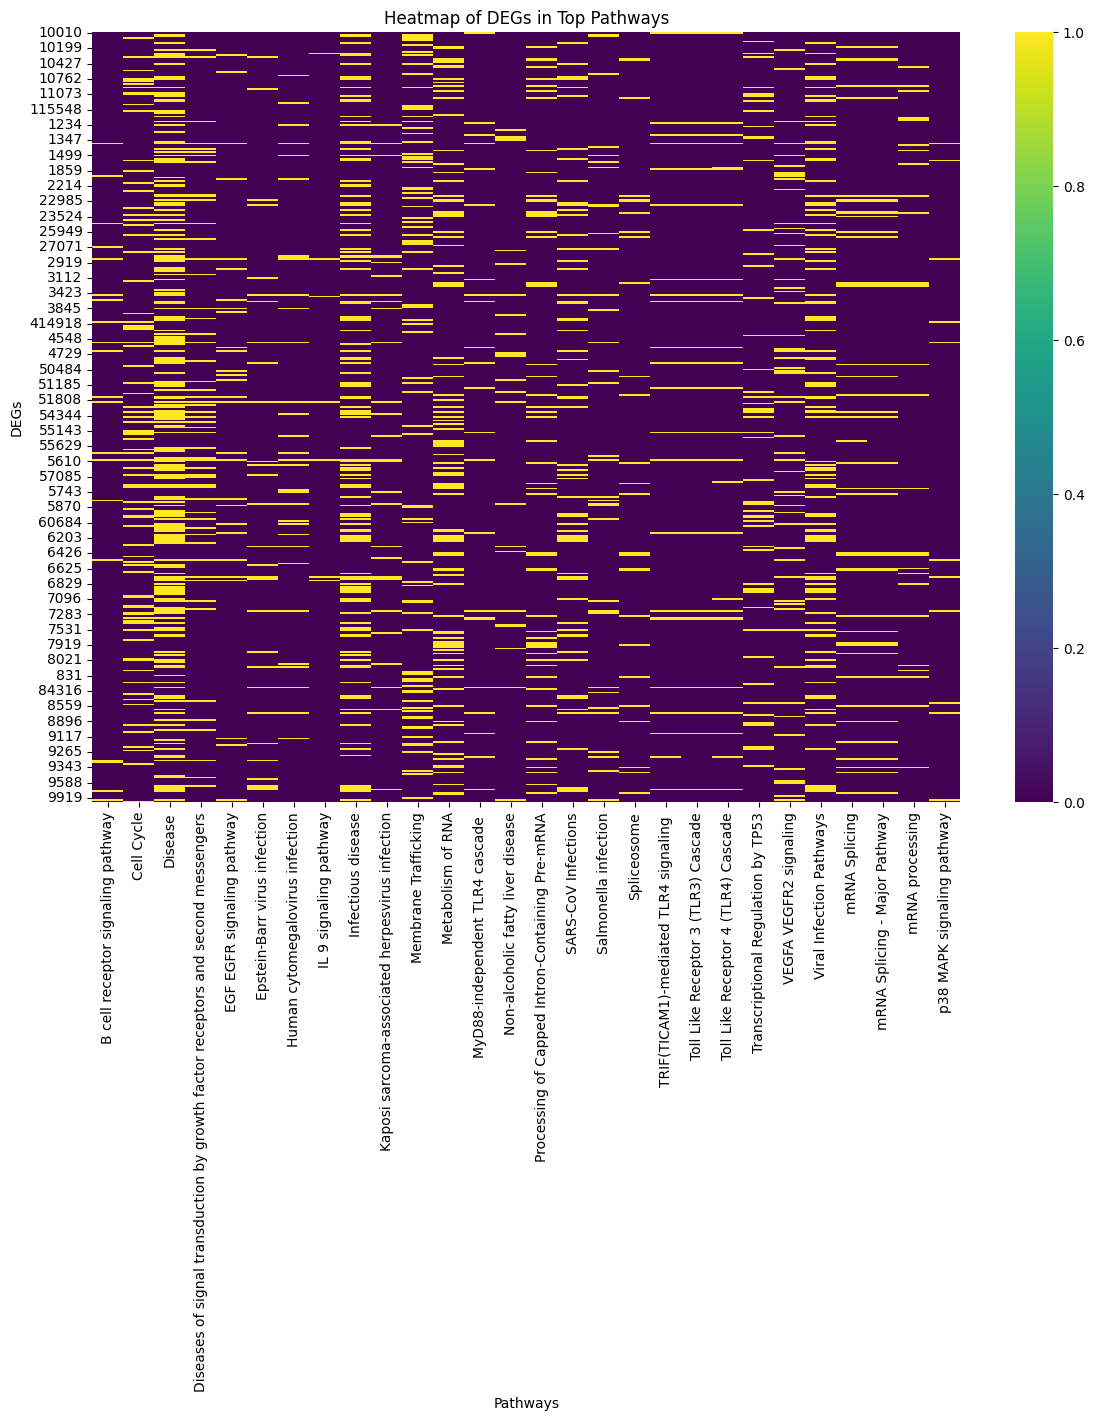

In [36]:
# Create a binary matrix for genes and pathways
pathway_genes = pathway_results.explode('intersections').pivot_table(
    index='intersections', columns='name', values='p_value', aggfunc='size', fill_value=0
)

# Heatmap of DEGs in pathways
plt.figure(figsize=(14, 10))
sns.heatmap(pathway_genes, cmap="viridis", cbar=True)
plt.title("Heatmap of DEGs in Top Pathways")
plt.xlabel("Pathways")
plt.ylabel("DEGs")
plt.xticks(rotation=90)
plt.show()